In [11]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as tfk
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow.keras.applications as tfka
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import keras_cv

print("Keras version:", tfk.__version__)
print("TensorFlow version:", tf.__version__)


Keras version: 3.3.3
TensorFlow version: 2.16.1


In [12]:
np.random.seed(42)
tf.random.set_seed(42)

seed = 42

dataset_file_path = '/kaggle/input/dataset-no-outliers/trainig_set_no_outliers.npz'

data = np.load(dataset_file_path)
X = data['images']
y = data['labels']

X = (X/255).astype("float32")

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=int(X.shape[0]*0.2),
    random_state=seed,
    stratify=y
)

y_train = to_categorical(y_train, num_classes=8)
y_val = to_categorical(y_val, num_classes=8)

# Define input shape and list of base models
input_shape = (96, 96, 3)
num_classes = 8
epochs = 1000
batch_size = 32


class_labels = {
    0: 'Basophil',
    1: 'Eosinophil',
    2: 'Erythroblast',
    3: 'Immature granulocytes',
    4: 'Lymphocyte',
    5: 'Monocyte',
    6: 'Neutrophil',
    7: 'Platelet'
}

# Compute class weights to address class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weight_dict = dict(enumerate(class_weights))

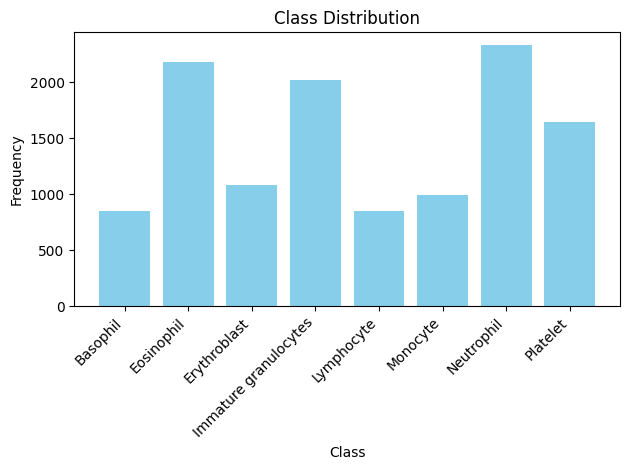

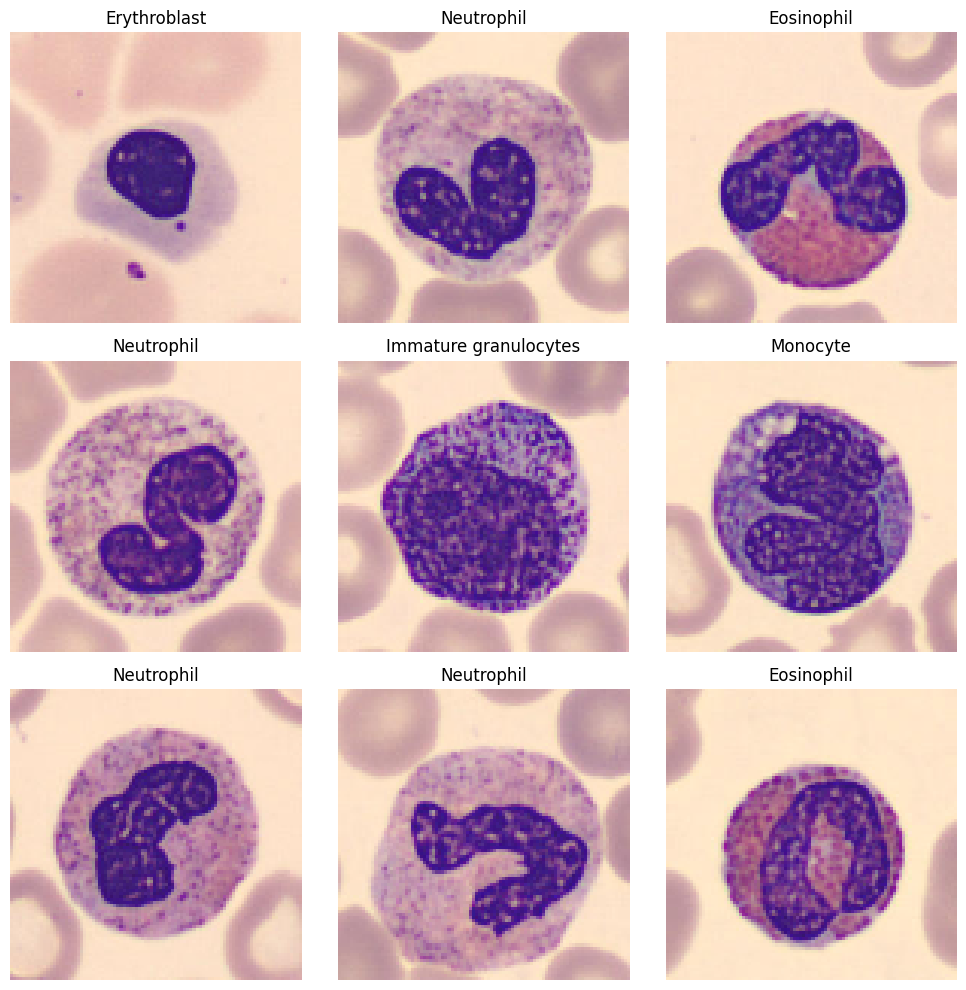

In [14]:
unique_labels, counts = np.unique(y, return_counts=True)
label_counts = {class_labels[label]: count for label, count in zip(unique_labels, counts)}

plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.tight_layout()  # Adjust layout for better appearance
plt.show()

import random

# Randomly select some indices
indices = random.sample(range(X.shape[0]), 9)

# Plot the images
plt.figure(figsize=(10, 10))
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[idx], cmap='gray')  # Use `cmap='gray'` if images are grayscale
    
    # Ensure y[idx] is an integer
    label_index = int(y[idx]) if y[idx].ndim == 0 else int(y[idx][0])
    
    plt.title(class_labels[label_index])  # Use the label index
    plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
augmix_layer = keras_cv.layers.AugMix(value_range=(0,1),
                                      severity=0.2,
                                      num_chains=3,
                                      chain_depth=(1, 3),
                                      alpha=1.0)

gaussian_noise_layer = tf.keras.layers.GaussianNoise(stddev=0.25)

# Define preprocessing function
def preprocess_image(image, label):
    image = augmix_layer(image)
    image = gaussian_noise_layer(image)
    return image, label
    
# Prepare tf.data.Dataset with AugMix preprocessing
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
print(train_dataset.take(1))
    
for image_batch, label_batch in train_dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Pixel value range:", tf.reduce_min(image_batch).numpy(), "-", tf.reduce_max(image_batch).numpy())


<_TakeDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None))>
Image batch shape: (32, 96, 96, 3)
Pixel value range: 0.0120005105 - 1.0000001


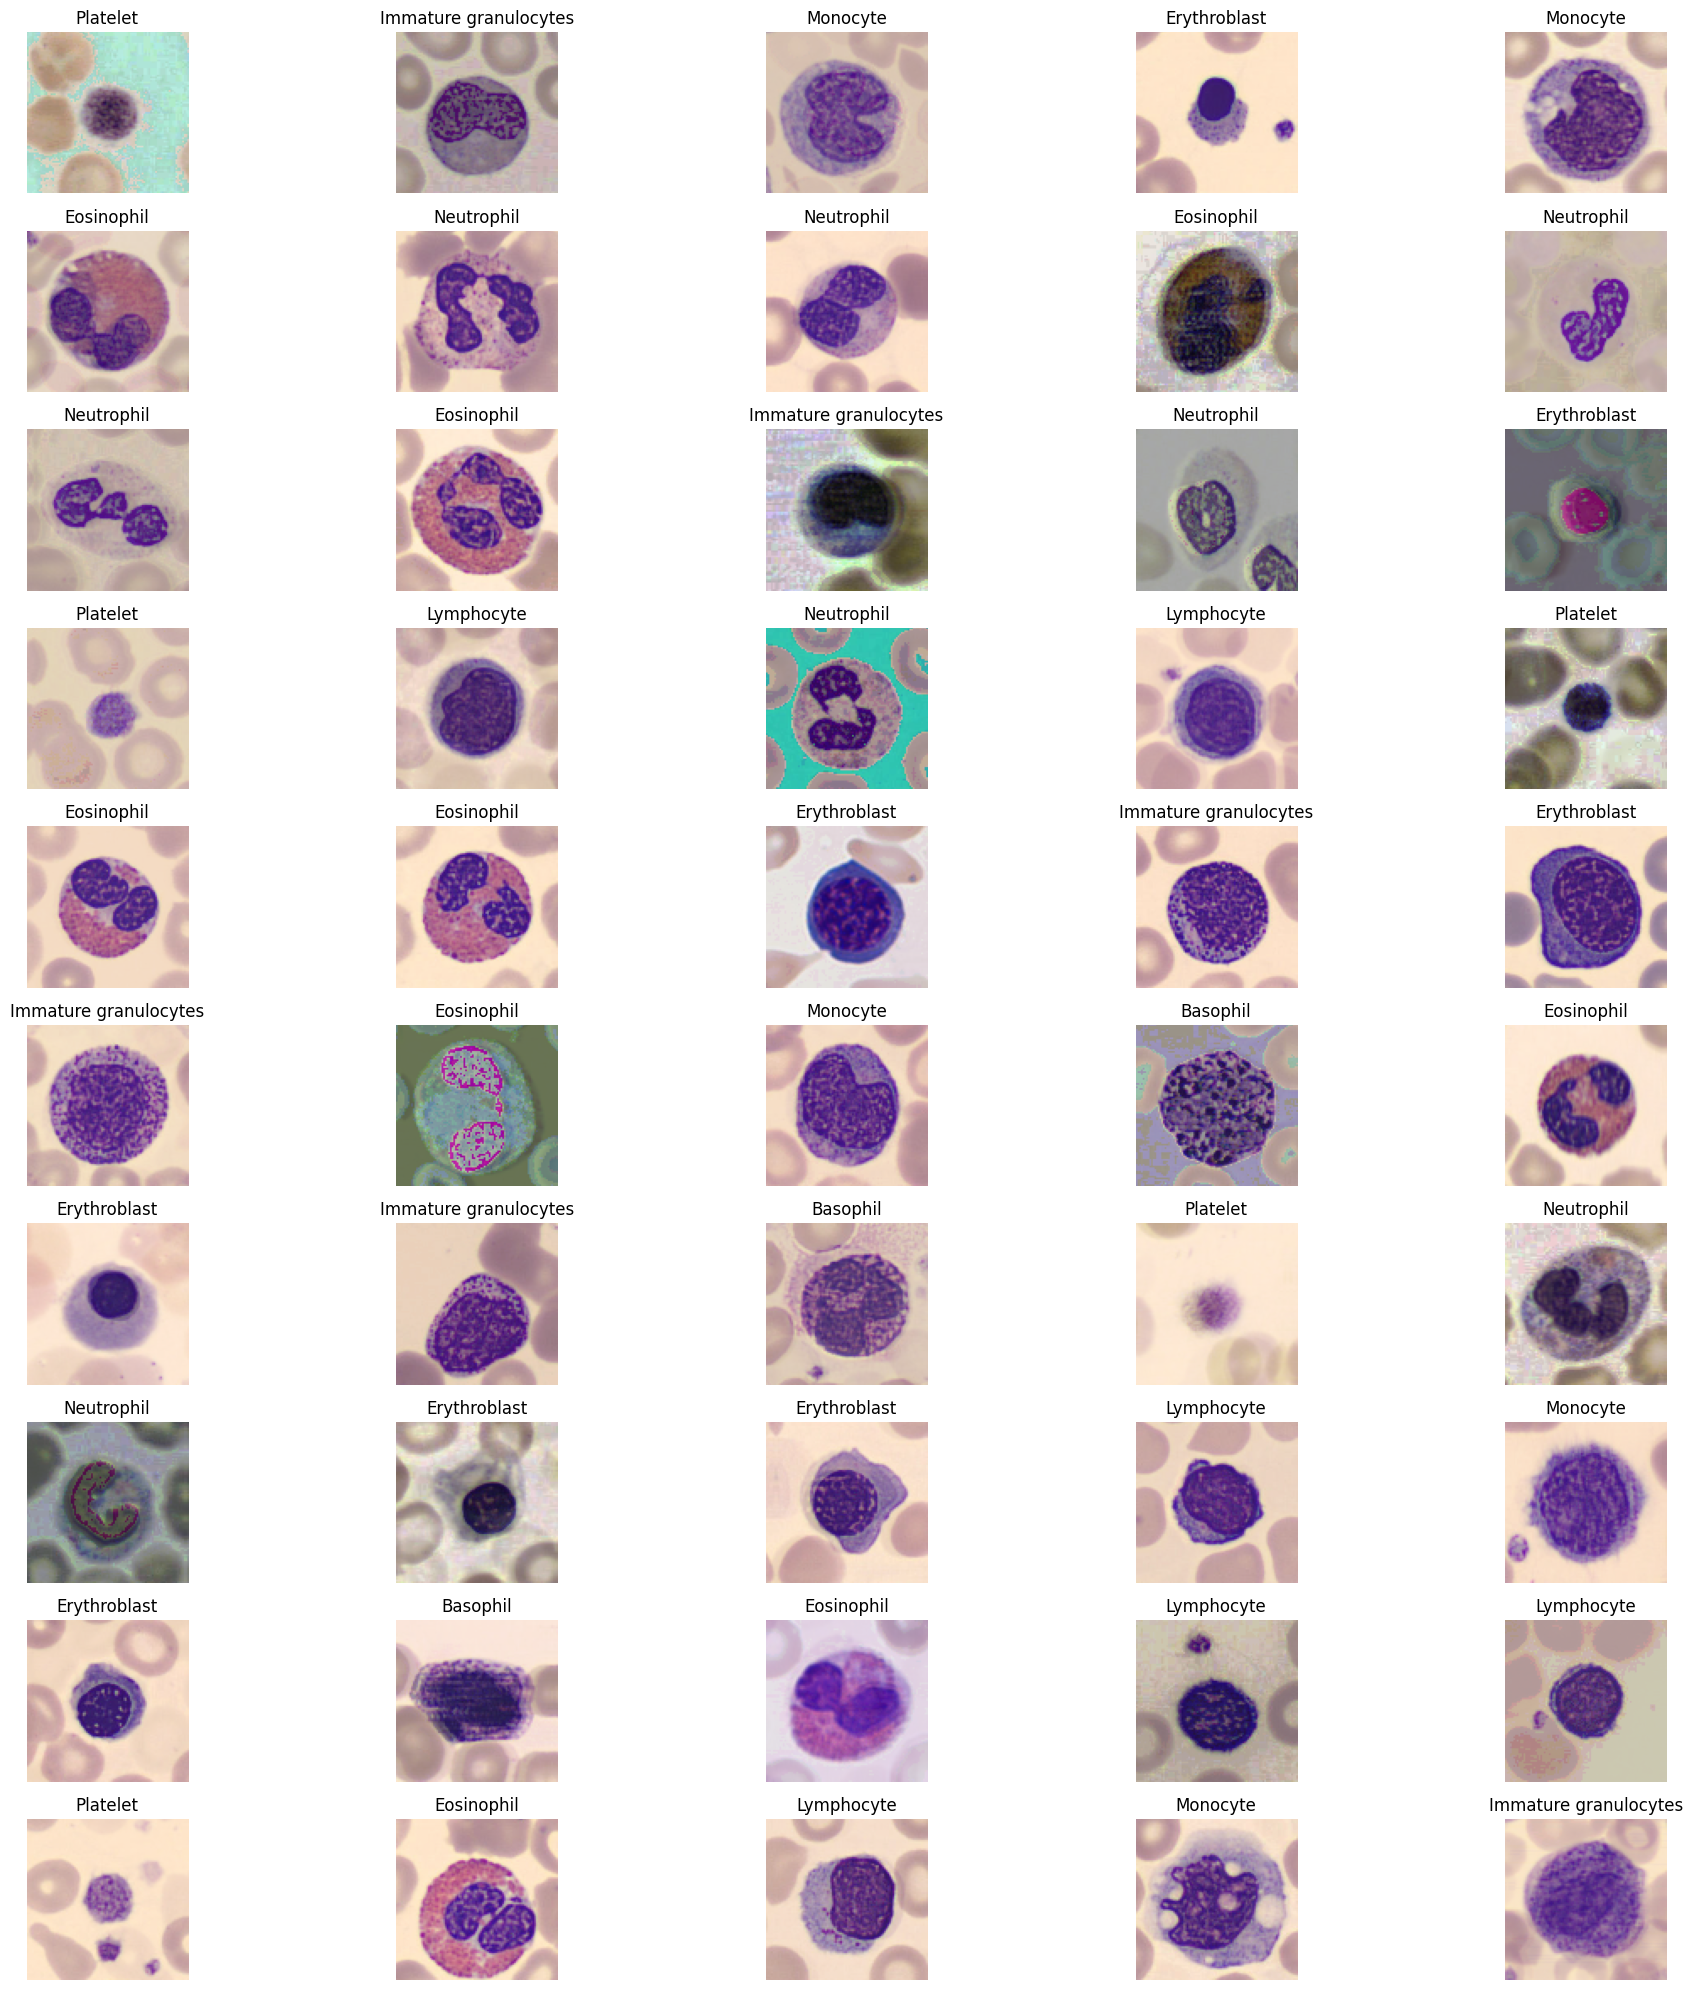

In [16]:
def show_random_augmented_images_one_hot(dataset, num_images=50):
    plt.figure(figsize=(20, 20))
    selected_images = []

    # Collect images and labels from the dataset
    for batch_images, batch_labels in dataset:
        for image, label in zip(batch_images, batch_labels):
            # Convert one-hot encoded label to integer index
            label_index = np.argmax(label.numpy())
            selected_images.append((image.numpy(), label_index))
            if len(selected_images) >= num_images:
                break
        if len(selected_images) >= num_images:
            break

    # Shuffle the selected images randomly
    np.random.shuffle(selected_images)

    # Display the images
    for i in range(num_images):
        image, label_index = selected_images[i]
        plt.subplot(10, 5, i + 1)  # Display in a 10x5 grid
        plt.imshow(image)
        plt.title(class_labels[label_index])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display 50 random augmented images from the train_dataset
show_random_augmented_images_one_hot(train_dataset)

In [ ]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Flip casuale
    tf.keras.layers.RandomRotation(0.2),                   # Rotazione casuale
    tf.keras.layers.RandomZoom(0.2),                       # Zoom casuale
    tf.keras.layers.RandomTranslation(0.2, 0.2),           # Traslazione casuale
    tf.keras.layers.RandomContrast(0.2),                   # Variazione del contrasto
    tf.keras.layers.RandomBrightness(0.2),                 # Variazione della luminosità
])

base_model = tfka.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg')

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=input_shape)
#X = data_augmentation(inputs)
X = base_model(inputs)

X = tf.keras.layers.Dense(512, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)

X = tf.keras.layers.Dense(256, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)

#X = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(X)
#X = tf.keras.layers.Dropout(0.2)(X)

outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(X)

tl_model = tfk.Model(inputs=inputs, outputs=outputs, name="CNN")

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9)


tl_model.compile(optimizer=optimizer,
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False), #tf.keras.losses.SigmoidFocalCrossEntropy()
      metrics=['accuracy'])
print(tl_model.summary())

# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 20,
                                                 verbose = 1,
                                                 restore_best_weights = True)


history = tl_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    class_weight=class_weight_dict,
    callbacks=[early_stopper, reduce_lr]
)

"""
history = tl_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    class_weight=class_weight_dict,
    callbacks=[early_stopper, reduce_lr]
)
"""

val_loss_final, val_accuracy_final = tl_model.evaluate(X_val, y_val)
print(f"Final Validation Accuracy: {val_accuracy_final * 100:.2f}%")
print(f"Final Validation Loss: {val_loss_final:.4f}")

model_filename = base_model.name.lower() + f"{val_accuracy_final * 100:.2f}" + "_tl" + ".keras"
print(f"Saving best model as: {model_filename}")
tl_model.save(model_filename)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,047,240 (11.62 MB)

 Trainable params: 789,256 (3.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Epoch 1/1000
299/299 ━━━━━━━━━━━━━━━━━━━━ 68s 195ms/step - accuracy: 0.5247 - loss: 1.3230 - val_accuracy: 0.8480 - val_loss: 0.4400 - learning_rate: 1.0000e-04
Epoch 2/1000
299/299 ━━━━━━━━━━━━━━━━━━━━ 53s 176ms/step - accuracy: 0.7600 - loss: 0.6557 - val_accuracy: 0.8618 - val_loss: 0.3968 - learning_rate: 1.0000e-04
Epoch 3/1000
299/299 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - accuracy: 0.7931 - loss: 0.5585 - val_accuracy: 0.8894 - val_loss: 0.3225 - learning_rate: 1.0000e-04
Epoch 4/1000
299/299 ━━━━━━━━━━━━━━━━━━━━ 53s 178ms/step - accuracy: 0.8129 - loss: 0.5067 - val_accuracy: 0.8907 - val_loss: 0.3159 - learning_rate: 1.0000e-04
Epoch 5/1000
299/299 ━━━━━━━━━━━━━━━━━━━━ 53s 178ms/step - accuracy: 0.8338 - loss: 0.4566 - val_accuracy: 0.8949 - val_loss: 0.3011 - learning_rate: 1.0000e-04
Epoch 6/1000
299/299 ━━━━━━━━━━━━━━━━━━━━ 53s 177ms/step - accuracy: 0.8381 - loss: 0.4583 - val_accuracy: 0.9054 - val_loss: 0.2813 - learning_rate: 1.0000e-04
Epoch 7/1000
299/299 ━━━━━━━━

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [7]:
ft_model = tfk.models.load_model(model_filename)

for layer in base_model.layers:
        layer.trainable = True

for layer in base_model.layers:
    layer.trainable = False

for i, layer in enumerate(base_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        if i >= 128:
            layer.trainable = True
            print(i, layer.name, type(layer).__name__, layer.trainable)

"""
history = ft_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    class_weight=class_weight_dict,
    callbacks=[early_stopper, reduce_lr]
)
"""

history = tl_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    class_weight=class_weight_dict,
    callbacks=[early_stopper, reduce_lr]
)



val_loss_final, val_accuracy_final = tl_model.evaluate(X_val, y_val)
print(f"Final Validation Accuracy: {val_accuracy_final * 100:.2f}%")
print(f"Final Validation Loss: {val_loss_final:.4f}")

model_filename = base_model.name.lower() + f"{val_accuracy_final * 100:.2f}" + "_ft" + ".keras"
print(f"Saving best model as: {model_filename}")
ft_model.save(model_filename)

132 block4e_se_reduce Conv2D True
133 block4e_se_expand Conv2D True
135 block4e_project_conv Conv2D True
139 block4f_expand_conv Conv2D True
142 block4f_dwconv2 DepthwiseConv2D True
147 block4f_se_reduce Conv2D True
148 block4f_se_expand Conv2D True
150 block4f_project_conv Conv2D True
154 block5a_expand_conv Conv2D True
157 block5a_dwconv2 DepthwiseConv2D True
162 block5a_se_reduce Conv2D True
163 block5a_se_expand Conv2D True
165 block5a_project_conv Conv2D True
167 block5b_expand_conv Conv2D True
170 block5b_dwconv2 DepthwiseConv2D True
175 block5b_se_reduce Conv2D True
176 block5b_se_expand Conv2D True
178 block5b_project_conv Conv2D True
182 block5c_expand_conv Conv2D True
185 block5c_dwconv2 DepthwiseConv2D True
190 block5c_se_reduce Conv2D True
191 block5c_se_expand Conv2D True
193 block5c_project_conv Conv2D True
197 block5d_expand_conv Conv2D True
200 block5d_dwconv2 DepthwiseConv2D True
205 block5d_se_reduce Conv2D True
206 block5d_se_expand Conv2D True
208 block5d_project_co

In [ ]:
dataset_file_path = '/kaggle/input/dataset-no-outliers/trainig_set_no_outliers.npz'

data = np.load(dataset_file_path)
X = data['images']
y = data['labels']

test_loss, test_accuracy_final = tl_model.evaluate(X, y)
print(f"Final Validation Accuracy: {val_accuracy_final * 100:.2f}%")
print(f"Final Validation Loss: {val_loss_final:.4f}")

# GRID SEARCH AND HYPERPARAMETERS TUNING

In [ ]:
def create_model(learning_rate=0.0001, dropout_rate=0.2, num_units=512, model = tfk.applications.EfficientNetV2S(input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg')):
    base_model = model
    base_model.trainable = False

    inputs = tf.keras.layers.Input(shape=input_shape)
    # X = data_augmentation(inputs)
    X = base_model(inputs)

    X = tf.keras.layers.Dense(num_units, activation='relu')(X)
    X = tf.keras.layers.Dropout(dropout_rate)(X)

    X = tf.keras.layers.Dense(num_units // 2, activation='relu')(X)  # Ridotto rispetto al primo strato
    X = tf.keras.layers.Dropout(dropout_rate)(X)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(X)

    model = tfk.Model(inputs=inputs, outputs=outputs, name="CNN")

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

# Funzione di addestramento con callback
def fit_with_callbacks(model, train_data, val_data, epochs, class_weight, callbacks):
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        class_weight=class_weight,
        callbacks=callbacks
    )
    return history

# Wrappa il modello con KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Definisci i parametri da esplorare con GridSearchCV
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],  # Diverse opzioni di learning rate
    'dropout_rate': [0.2, 0.3, 0.4],         # Diversi tassi di dropout
    'num_units': [256, 512, 1024],            # Numero di neuroni negli strati Dense
    'epochs': [10, 20],                       # Numero di epoche per ogni esecuzione
    'batch_size': [32, 64]                    # Batch size
}

# Definisci i callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 mode='max',
                                                 min_delta=0.01,
                                                 patience=3,
                                                 factor=0.25,
                                                 verbose=1,
                                                 cooldown=0,
                                                 min_lr=0.00000001)

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                 mode='max',
                                                 min_delta=0.005,
                                                 patience=20,
                                                 verbose=1,
                                                 restore_best_weights=True)

callbacks = [early_stopper, reduce_lr]

# Definisci GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Esegui GridSearchCV passando la funzione personalizzata per l'addestramento
grid_result = grid.fit(train_dataset)  # Usa il dataset TensorFlow per il fitting

# Visualizza i risultati migliori
print(f"Best Score: {grid_result.best_score_}")
print(f"Best Params: {grid_result.best_params_}")

# Usa il modello migliore sui dati di test
best_model = grid_result.best_estimator_

# Valutazione finale sui dati di validazione
val_loss_final, val_accuracy_final = best_model.score(X_val, y_val)
print(f"Final Validation Accuracy: {val_accuracy_final * 100:.2f}%")
print(f"Final Validation Loss: {val_loss_final:.4f}")

# Addestra il modello finale con i parametri migliori sui dati di addestramento
best_model.fit(train_dataset,
               validation_data=val_dataset,
               class_weight=class_weight_dict,
               callbacks=[early_stopper, reduce_lr])